# CNN Time Series Forecasting (EUR-USD Financial Dataset example)


## IADS Summer School 2023

### Dr Michael Fairbank, University of Essex, UK

- Email: m.fairbank@essex.ac.uk
- This is a Jupyter Notebook to accompany lecture 4 of the course

## Objective

- We've seen that CNNs are very good at image classification.

- In this notebook we will use a CNN to forecast the EUR/USD exchange rate.

## Load dataset

We use Pandas to load the csv file very easily in Python.  Pandas also lets us easily manipulate and view the data.

This dataset came from my own Interactive Brokers account.



In [7]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#df0 = pd.read_csv("datasets/eurusd60s_2013_2018.csv.zip", compression='zip', sep=',') # This data is minute-by-minute data.
# If the above line fails then try the following line instead, to download it directly from 
# my google drive account
df0 = pd.read_csv("https://drive.google.com/uc?export=download&id=1o052vfAJRCKcZD2-fLLe-9CBQd-WWhjN", compression='zip', sep=',')

df0 = df0[0::(60)] # Reduce data down to hourly.


URLError: <urlopen error [Errno 8] nodename nor servname provided, or not known>

Let's take a glance at the data. Here are the first few rows.  


In [3]:
print(df0.head())
print(df0.describe().transpose())

NameError: name 'df0' is not defined

- Note the volume data is missing for this Forex data.

- In real trading you buy at the ask prices and sell at the bid prices, so always lose a bit of money due to the difference in any transaction.  Plus there are usually other commission costs and price slippage.  We will only look at bid prices in this exercise.

- The high and low prices for each bar were calculated on the minute-by-minute data so are invalid now we have trucated down to hourly data.  Hence we should only look at open_bid price in this exercise.

## View data graphically

NameError: name 'df0' is not defined

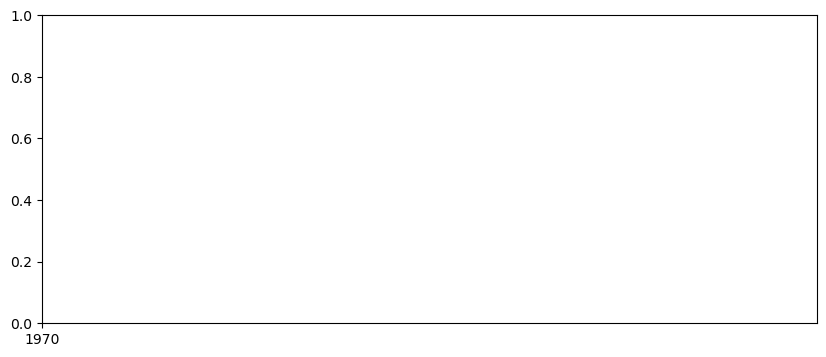

In [2]:
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(10, 4))
ax = plt.gca()
formatter = mdates.DateFormatter("%Y")
ax.xaxis.set_major_formatter(formatter)
locator = mdates.YearLocator()
ax.xaxis.set_major_locator(locator)
plt.plot(pd.to_datetime(df0['date']), df0['bid_open']) # Only look at one of the price columns (for simplicity)
plt.title('Times Series for EUR/USD');
plt.grid()
plt.show()

## Calculate log returns, and simplify dataset

The log return of a price at time $p_t$ is $log(p_t/p_{t-1})$.  This tells you the ratio that a price has changed by in any one time step.  It will be positive if $p_t>p_{t-1}$ and negative otherwise.

In [4]:
price_col=df0["bid_open"].values
price_return=np.log(price_col[1:]/price_col[:-1])
price_col=price_col[1:]
df=pd.DataFrame(columns=["price","return"], data=np.stack([price_col,price_return],axis=1))
print(df.head())

     price    return
0  1.32070  0.000757
1  1.32755  0.005173
2  1.32935  0.001355
3  1.32860 -0.000564
4  1.32605 -0.001921


## Split the Data

- We'll use a `(70%, 30%)` split for the training and validation. 

- Note, the data is **not** being randomly shuffled before splitting. 

    - We must not shuffle the validation set into the training dataset - that would be cheating ourselves.


In [5]:
n = len(df)
train_df = df[0:int(n*0.7)] # takes the first 70% of the data and puts it into the "training" dataframe
val_df = df[int(n*0.7):n] # takes the final 30% of the data and puts it into the "training" dataframe

## Choose input columns and target output columns for forecasting objective:

Here we decide which columns to show the neural network, and which columns we'd like it to be trained to predict.  
- We are going to try to forecast future prices based on old prices.

In [6]:
input_columns=[0] # this is the price column
target_columns=[1] # This is the return column 
print("Input columns", list(train_df.columns[input_columns]))
print("Target columns", list(train_df.columns[target_columns]))

Input columns ['price']
Target columns ['return']


## Prepare input and output time sequences

We want the RNN to receive a stream of data, corresponding to the above input columns, spread over time, and to make a forecast of the target column quantity for look_ahead timesteps ahead.

We will prepare this data as 3d tensors suitable for input to Keras RNNs, so of shape [batch_size, time_sequence_length, data_width]

Note we say a time_sequence_length=40, and allow a warm_up_period=30, which gives the RNN 30 timesteps to observe the context on what the time series is doing before it is being challenged to make any predictions.  It will then have to make 10 consecutive predictions, where each prediction is look_head=1 hour.

In [7]:
def generate_input_and_target_tensor_for_cnn(df, input_cols, target_col, time_sequence_length, look_ahead):
    num_rows=len(df)
    data=np.array(df,np.float32)
    inputs=[]
    targets=[]
    for first_row in range(num_rows-time_sequence_length-look_ahead):
        input_windows=data[first_row:first_row+time_sequence_length,input_cols]
        input_windows-=data[first_row:first_row+1,input_cols]
        inputs.append(input_windows) # this will make each window start with 0, and be relative to the start price
        output_labels=data[first_row+time_sequence_length-1+look_ahead,target_col]
        output_labels=(output_labels>0).astype(np.float32) # this will turn it into a classification task
        targets.append(output_labels)
    inputs=np.stack(inputs)
    inputs=np.expand_dims(inputs,3) # adds a dummy "channel" to the tensor, i.e. reshapes it to [batch_size, window_size, 1, 1]
    targets=np.stack(targets)
    return inputs, targets.reshape((-1))

        
time_sequence_length=40
look_ahead=1
[inputs_tensor_train,targets_tensor_train]=generate_input_and_target_tensor_for_cnn(train_df, input_columns, target_columns, time_sequence_length, look_ahead)
[inputs_tensor_val,targets_tensor_val]=generate_input_and_target_tensor_for_cnn(val_df, input_columns, target_columns, time_sequence_length, look_ahead)

# normalise all of the input datasequences:
mean_window_price_change=(inputs_tensor_train[:,-1,:,:]).std()
inputs_tensor_train/=mean_window_price_change
inputs_tensor_val/=mean_window_price_change

# Quick review that things look sane...
print("inputs",inputs_tensor_train.shape)
print("targets",targets_tensor_train.shape)
print("input window 0",inputs_tensor_train[0,:,0])
print("label for windows 0:4",targets_tensor_train[0:4])


inputs (25336, 40, 1, 1)
targets (25336,)
input window 0 [[ 0.        ]
 [ 0.8404943 ]
 [ 1.0613468 ]
 [ 0.9693285 ]
 [ 0.65644324]
 [ 0.7239174 ]
 [ 0.7914062 ]
 [ 0.80980694]
 [ 0.91411173]
 [ 0.699388  ]
 [ 0.46624893]
 [ 0.515337  ]
 [ 0.7361894 ]
 [ 0.50919366]
 [ 0.5828112 ]
 [ 0.39263144]
 [-0.1472496 ]
 [-0.47240686]
 [-0.527609  ]
 [-0.38651738]
 [-0.26381183]
 [-0.36810204]
 [-0.3190286 ]
 [-0.26381183]
 [-0.45399153]
 [-0.44786283]
 [-0.9263838 ]
 [-0.8282369 ]
 [-0.87731034]
 [-0.8343656 ]
 [-0.74233276]
 [-0.68713063]
 [-0.53988105]
 [-1.1411076 ]
 [-1.2085963 ]
 [-1.2576844 ]
 [-1.3497026 ]
 [-1.1533796 ]
 [-1.251541  ]
 [-1.1779236 ]]
label for windows 0:4 [0. 1. 0. 0.]


## Try to visualise the input data sequences

- The dataset has been split into a set of "time-windows", each of duration time_sequence_length.
- They have been arranged all to show data relative to their starting value (so they should all appear to start from zero).
- Each time window has a data label of 0 or 1 (1 means the price next moves up next, 0 means it goes down)

Let's plot the first few time windows to see if they make sense:

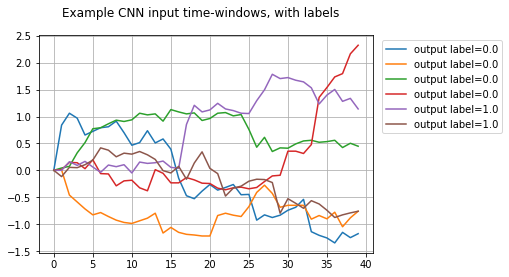

In [8]:
#plt.ylabel(train_df.columns[target_columns][0])
for i in range(6):
    plt.plot(inputs_tensor_train[i*time_sequence_length,:,0,0],label="output label="+str(targets_tensor_train[i*time_sequence_length]))
plt.legend(bbox_to_anchor=(1.4, 1), loc="upper right")
plt.grid()
plt.suptitle('Example CNN input time-windows, with labels')
plt.show()

## Data normalisation

- Remember that neural networks like their inputs and outputs to be scaled nicely.  All roughly centred on zero with approximate magnitude 1.
    
Q: Have we achieved that here?

## Build CNN  Model 

In [11]:

model=tf.keras.Sequential([
        tf.keras.layers.Conv2D(20, kernel_size=(5,1), activation="tanh",padding="same"),
        tf.keras.layers.Conv2D(20, kernel_size=(5,1), activation="tanh",padding="same"),
        tf.keras.layers.MaxPool2D(pool_size=(2,1)),
        tf.keras.layers.Conv2D(20, kernel_size=(5,1), activation="tanh",padding="same"),
        tf.keras.layers.Conv2D(20, kernel_size=(5,1), activation="tanh",padding="same"),
        tf.keras.layers.MaxPool2D(pool_size=(2,1)),
        tf.keras.layers.Conv2D(20, kernel_size=(5,1), activation="tanh",padding="same"),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(2,activation=None)
    ])
print(model(inputs_tensor_train[0:1]))
model.summary()

tf.Tensor([[-0.06358559  0.39526463]], shape=(1, 2), dtype=float32)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (1, 40, 1, 20)            120       
                                                                 
 conv2d_4 (Conv2D)           (1, 40, 1, 20)            2020      
                                                                 
 max_pooling2d_2 (MaxPooling  (1, 20, 1, 20)           0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (1, 20, 1, 20)            2020      
                                                                 
 conv2d_6 (Conv2D)           (1, 20, 1, 20)            2020      
                                                                 
 max_pooling2d_3 (MaxPooling  (1, 10, 1, 20)        

## Compile + Train Model

Specify the optimiser (Adam) and the loss function to use.  This is a regression task (we are forecasting a real number) so we use MeanSquaredError.

In [12]:
model.compile(
    optimizer=keras.optimizers.Adam(0.001),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    # List of metrics to monitor
    metrics=["sparse_categorical_accuracy"],
)

history = model.fit(
    inputs_tensor_train,
    targets_tensor_train,
    batch_size=100,
    epochs=20,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(inputs_tensor_val, targets_tensor_val),
)

Epoch 1/20
254/254 [==============================] - 7s 22ms/step - loss: 0.6939 - sparse_categorical_accuracy: 0.5052 - val_loss: 0.6932 - val_sparse_categorical_accuracy: 0.5119
Epoch 2/20
254/254 [==============================] - 5s 19ms/step - loss: 0.6925 - sparse_categorical_accuracy: 0.5178 - val_loss: 0.6933 - val_sparse_categorical_accuracy: 0.5154
Epoch 3/20
254/254 [==============================] - 5s 19ms/step - loss: 0.6919 - sparse_categorical_accuracy: 0.5176 - val_loss: 0.6936 - val_sparse_categorical_accuracy: 0.5132
Epoch 4/20
254/254 [==============================] - 5s 19ms/step - loss: 0.6914 - sparse_categorical_accuracy: 0.5219 - val_loss: 0.6932 - val_sparse_categorical_accuracy: 0.5092
Epoch 5/20
254/254 [==============================] - 5s 19ms/step - loss: 0.6910 - sparse_categorical_accuracy: 0.5265 - val_loss: 0.6931 - val_sparse_categorical_accuracy: 0.5121
Epoch 6/20
254/254 [==============================] - 5s 20ms/step - loss: 0.6907 - sparse_cate

## Visualise training progress
- We can use these graphs to decide how much "overfitting" might have happened.

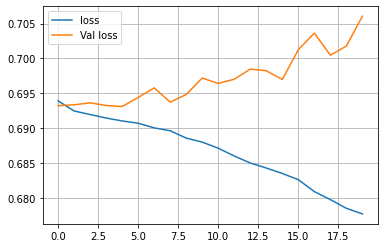

In [13]:
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"],label="Val loss")
plt.legend()
plt.grid()

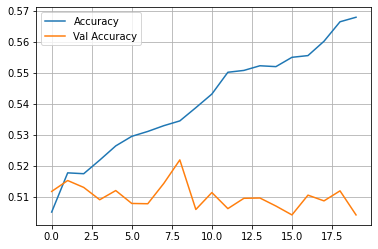

In [14]:
plt.plot(history.history["sparse_categorical_accuracy"], label="Accuracy")
plt.plot(history.history["val_sparse_categorical_accuracy"],label="Val Accuracy")
plt.legend()
plt.grid()

In [15]:
# Check what the base rate is:
print("Training set label mean",targets_tensor_train.mean())
print("Validation set label mean",targets_tensor_val.mean())


Training set label mean 0.4834228
Validation set label mean 0.48555607


## Things to try:

1. In line 10 of generate_input_and_target_tensor_for_cnn, change the -1 to -2, and see (and try to predict) what will happen.  
2. Calculate the base rates - what is the average validation set mean label, and how does this compare to your results?
3. Try to change the data frequency from hourly to something else (e.g. 5-minute bars), or change the window size (specified by variable time_sequence_length)
4. If you train for a longer time, what is the highest accuracy you can get on the Training Set/ Validation Set?

## Further work

- Try to add fancier layers (e.g. dropout layers)

- Add more useful inputs, e.g. other correlating stocks, sentiment information, technical "indicators" such as moving average, RSI indicator, CCI indicator, etc.

- In Future work, get your own data, e.g. see https://towardsdatascience.com/time-series-and-correlations-with-stock-market-data-using-python-e66774e3a16f.  This includes sentiment data.  Also you can trawl through a wider range of commodities.

- Train ensemble of models.  The average of several independent models is nearly always better than any of the individual models (!).

- Note that we are always fighting against the fundamental problem of market's ability to adaptation and be efficient.